In [1]:
import torch
import torch.nn as nn

**Checking whether mps is available or not**

In [2]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.1.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Create data and send it to the device
mps = torch.rand(size=(3, 4)).to(device)
mps

tensor([[0.2112, 0.7101, 0.4978, 0.1997],
        [0.2495, 0.5283, 0.0804, 0.2434],
        [0.7557, 0.4254, 0.2272, 0.7192]], device='mps:0')

**Constructing Discriminator Network**

In [4]:
class Discriminator(nn.Module):
    
    def __init__(self,channels_img, features_d):
        
        super(Discriminator,self).__init__()
        
        self.disc = nn.Sequential(
            
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1 ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            
        )
                
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        
        return nn.Sequential(
            
            nn.Conv2d( in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True), # in the paper, they used layernorm
            nn.LeakyReLU(0.2)
            
        )
    
    def forward(self, x):
        return self.disc(x)     

**Constructing Generator Network**

In [5]:
class Generator(nn.Module):
    
    def __init__(self, z_dim, channels_img, features_g):
        
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            
            self._block(z_dim, features_g*16, 4, 1, 0), 
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        
        return nn.Sequential(
            
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()            
        
        )   
    
    def forward(self, x):
        return self.gen(x)

In [6]:
def initialize_weights(model):
    
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N,1,1,1)
    
    
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

In [7]:
test()

Success


**Adding Gradient Penalty**

In [8]:
def gradient_penalty(critic, real, fake, device="cpu"):
    
    BATCH_SIZE, C, H, W = real.shape

    epsilon = torch.rand((real.shape[0], 1, 1, 1)).repeat(1, C, H, W).to(device)

    interpolated_images = real * epsilon + fake * (1 - epsilon)
    
    # calculate critic scores
    
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.shape [0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

**TRAINING SETUP**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

Hyperparameters

In [10]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [11]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [12]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms, download=True
)

 DATA LOADER

In [13]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(critic)

OPTIMIZER & CRITERION

In [14]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=((0.0, 0.9)))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=((0.0, 0.9)))

In [15]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0


In [16]:
for epoch in range(NUM_EPOCHS):
    
    
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        
        current_batch_size = real.shape[0]
        
        noise = torch.randn(current_batch_size, Z_DIM, 1, 1).to(device)
        
        
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(current_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp)
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()      
            
                
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        # Print losses occasionally and print to tensorboard
        
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            gen.train()
            critic.train()


Epoch [0/5] Batch 0/938                   Loss D: 61.9099, loss G: 2.9380
Epoch [0/5] Batch 100/938                   Loss D: -92.7323, loss G: 85.7143
Epoch [0/5] Batch 200/938                   Loss D: -70.1126, loss G: 74.7022
Epoch [0/5] Batch 300/938                   Loss D: -51.2523, loss G: 75.4844
Epoch [0/5] Batch 400/938                   Loss D: -35.7469, loss G: 67.1039
Epoch [0/5] Batch 500/938                   Loss D: -23.3806, loss G: 60.6231
Epoch [0/5] Batch 600/938                   Loss D: -15.6722, loss G: 60.4122
Epoch [0/5] Batch 700/938                   Loss D: -16.5021, loss G: 59.1503
Epoch [0/5] Batch 800/938                   Loss D: -19.1553, loss G: 58.5472
Epoch [0/5] Batch 900/938                   Loss D: -16.5542, loss G: 57.8037
Epoch [1/5] Batch 0/938                   Loss D: -15.0065, loss G: 61.2960
Epoch [1/5] Batch 100/938                   Loss D: -15.4737, loss G: 69.0380
Epoch [1/5] Batch 200/938                   Loss D: -14.3850, loss G: 

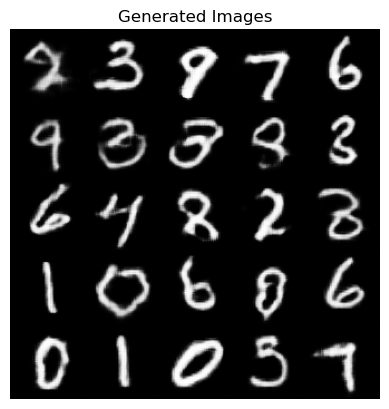

In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Assuming your generator model is named `gen` and is already loaded and set to evaluation mode
gen.eval()

# Generate a batch of fake images
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
with torch.no_grad():
    fake_images = gen(fixed_noise)

# Plotting function
def plot_fake_images(fake_images, num_images=25):
    # Make a grid from the images
    img_grid = vutils.make_grid(fake_images[:num_images], normalize=True, nrow=5)
    img_grid = img_grid.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C) for visualization
    plt.imshow(img_grid.cpu().numpy())
    plt.axis('off')
    plt.title("Generated Images")
    plt.show()

plot_fake_images(fake_images)


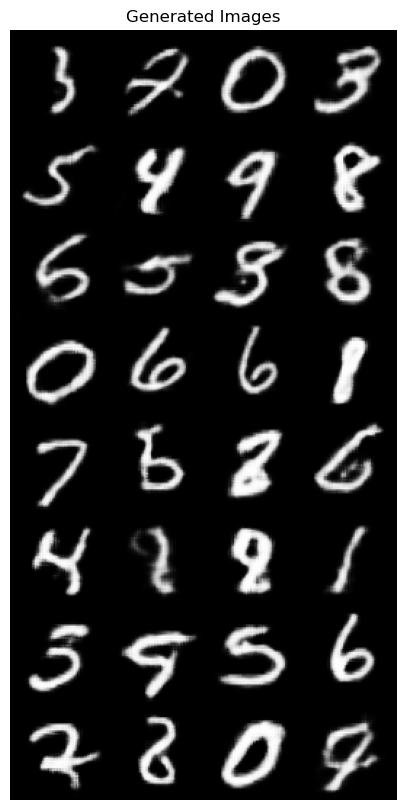

In [18]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Assuming your generator model is named `gen` and is already loaded and set to evaluation mode
gen.eval()

# Generate a batch of fake images
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
with torch.no_grad():
    fake_images = gen(fixed_noise)

# Plotting function
def plot_fake_images(fake_images, num_images=32):
    # Make a grid from the images
    img_grid = vutils.make_grid(fake_images[:num_images], normalize=True, nrow=4)  # Adjusted nrow to 4
    img_grid = img_grid.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C) for visualization
    plt.figure(figsize=(10, 10))  # Adjusted figure size for better visualization
    plt.imshow(img_grid.cpu().numpy())
    plt.axis('off')
    plt.title("Generated Images")
    plt.show()

plot_fake_images(fake_images)


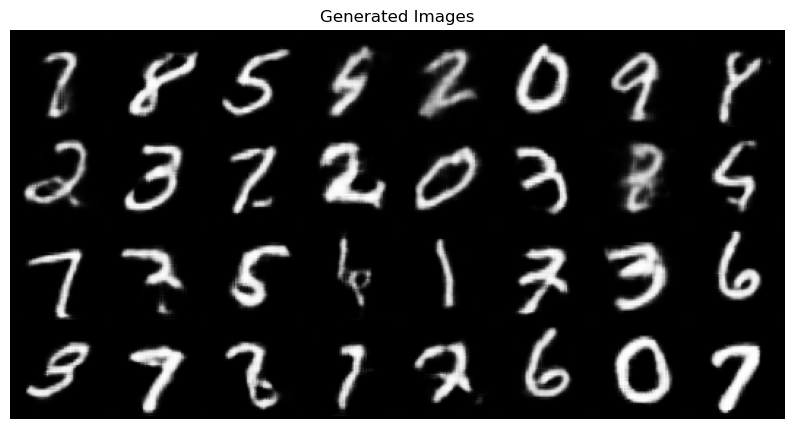

In [19]:
# Generate a batch of fake images
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
with torch.no_grad():
    fake_images = gen(fixed_noise)

# Plotting function
def plot_fake_images(fake_images, num_images=32):
    # Make a grid from the images
    img_grid = vutils.make_grid(fake_images[:num_images], normalize=True, nrow=8)  # Adjusted nrow to 4
    img_grid = img_grid.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C) for visualization
    plt.figure(figsize=(10, 10))  # Adjusted figure size for better visualization
    plt.imshow(img_grid.cpu().numpy())
    plt.axis('off')
    plt.title("Generated Images")
    plt.show()

plot_fake_images(fake_images)
